<div id="toc"></div>

<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Build Bicorrelation Histogram
Author: Patricia Schuster  
Affiliation: University of Michigan  
Date: January 2017

Updates:  
* 6/30/2017: Implement usage of `det_df` for `alloc_bhm` and `fill_bhm` (Steps 4, 5)  
* 7/5/2017: Update `built_bhm` to use `det_df`, take `dt_bin_edges` as input (Functionalize)

# Goal
My goal is to build a script or notebook that will produce bicorrelation plots for the FNPC fission CVT project.

The plots will be 2d histograms of $\Delta t_1$ vs. $\Delta t_2$ for two detectors, where $\Delta t$ for each detector is the time of an interaction relative to the time of the corresponding fission chamber interaction. 

Steps in the analysis:

1) Load the data from `bicorr1` (produced by `bicorr.generate_bicorr`)  
2) Make some benchmark plots to make sure the `bicorr1` data looks like what we expect  
3) Fill a giant matrix with histogram information about detector pair interactions  

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import scipy.io as sio
import sys
import time
import inspect
import pandas as pd
from tqdm import *

# Plot entire array
np.set_printoptions(threshold=np.nan)

In [2]:
import seaborn as sns
sns.set_palette('spectral')

In [3]:
sys.path.append('../scripts/')
import bicorr as bicorr

In [4]:
%load_ext autoreload
%autoreload 2

# Step 1) Load the data from `bicorr1`

I need to load the `bicorr#` file from each subfolder. Start by using the same technique I used to import the `cced` file. I built this into a function called `bicorr.load_bicorr`.

In [5]:
help(bicorr.load_bicorr)

Help on function load_bicorr in module bicorr:

load_bicorr(folder_number=None, bicorr_path=None, root_path=None)
    Load a data matrix of bicorr data into current python session
    
    Parameters
    ----------
    folder_number : int, optional
        Folder from which to load bicorr file
        Bicorr filename will be bicorr# (with folder_number)
    bicorr_path : str, optional
        Full path of bicorr file, including filename
    root_path : int, optional
        Relative path to folder where data folders exist (1, 2, 3, etc.). default = cwd
    
    
    Returns
    -------
    bicorr_data : ndarray
        Each element contains the following info for one bicorrelation pair
        Columns are 0: event, np.int32
                    1: det1ch, np.int8
                    2: det1par, np.int8
                    3: det1t, np.float16
                    4: det2ch, np.int8
                    5: det2par, np.int8
                    6: det2t, np.float16



In [5]:
bicorr_data = bicorr.load_bicorr(1, root_path = '../datar')

In [6]:
bicorr_data.shape

(695,)

I want to work with larger data, so I'm going to pull 10000 lines from the `bicorr1` file from flux (rather than the tiny `bicorr1` file produced from `cced1_part`. 

I used the same technique as before on flux:

`head -n 10000 bicorr1 > bicorr1_part`

And then I copied that to `datar > 1`

In [5]:
bicorr_data = bicorr.load_bicorr(bicorr_path = '../datar/1/bicorr1_part')

In [6]:
bicorr_data.shape

(10000,)

I can parse this array in the same way I did with the `cced` file. 

In [9]:
# Print all info from first line
print(bicorr_data[:][0])
# Print event number from line 0
print(bicorr_data['event'][0])

(22, 18, 1, 57.5, 19, 2, 2.84375)
22


# Step 2) Make some benchmark plots of the `1/bicorr1` data

* Which pairs had bicorrelation events?
* Count rates for each detector pair
* Event number vs. line

I wrote myself a convenient function for saving plots to file:

In [11]:
help(bicorr.save_fig_to_folder)

Help on function save_fig_to_folder in module bicorr:

save_fig_to_folder(fig_filename, fig_folder='fig')
    Summary: Save .png of current matplotlib plot to fig_folder / fig_filename
    Code will check to make sure fig_folder exists. If not, create folder then save .png to folder
    
    Parameters
    ----------
    fig_filename : str
        Filename to use for saving the figure
    fig_folder : str, optional
        Folder where to save the image, relative to cwd
    
    Returns
    -------
    n/a



In [7]:
fig_folder = 'fig'

## Detector pairs that had bicorrelation events

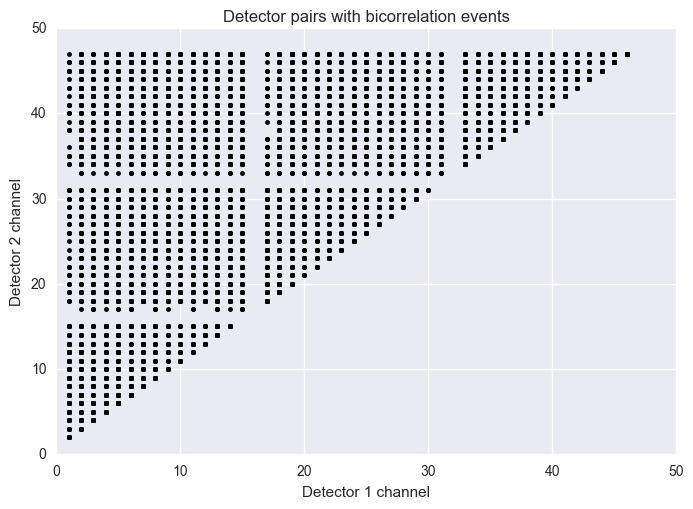

In [13]:
# Which detector pairs fired?
plt.plot(bicorr_data['det1ch'],bicorr_data['det2ch'],'.k')
plt.xlabel('Detector 1 channel')
plt.ylabel('Detector 2 channel')
plt.title('Detector pairs with bicorrelation events')
bicorr.save_fig_to_folder('bicorr_pairs_scatter',fig_folder)
plt.show()

## Count rate for each detector pair

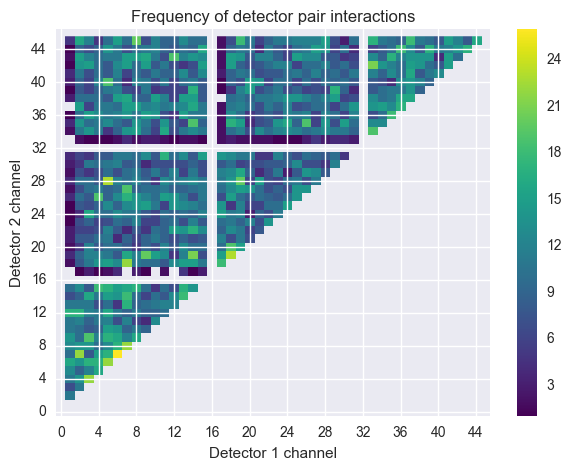

In [14]:
plt.figure(figsize=(7,5))
plt.hist2d(bicorr_data['det1ch'],bicorr_data['det2ch'],bins=np.arange(-0.5,46.5,1),cmin=1,cmap='viridis')
plt.ylim([-.5,46.5])
plt.colorbar()
plt.grid(True, which='both')
plt.xticks([i for i in np.arange(0,46,4)])
plt.yticks([i for i in np.arange(0,46,4)])
plt.xlabel('Detector 1 channel')
plt.ylabel('Detector 2 channel')
plt.title('Frequency of detector pair interactions')
bicorr.save_fig_to_folder('bicorr_pairs_2dhist',fig_folder)
plt.show()

I should take some time to explain the features on this plot. There are a few interesting observables:

* The first detector channel on each board has a noticeably smaller count rate (blue bands). This is because of an electronics issue that the first channel on each board will only write out if there is a trigger in a detector on the same board. Thus, if the bicorrelation event happens on that channel and a detector on another board, it won't be counted.
* The highest values along the diagonal correspond to detectors that are directly adjacent to one another, and will therefore experience more cross talk. 

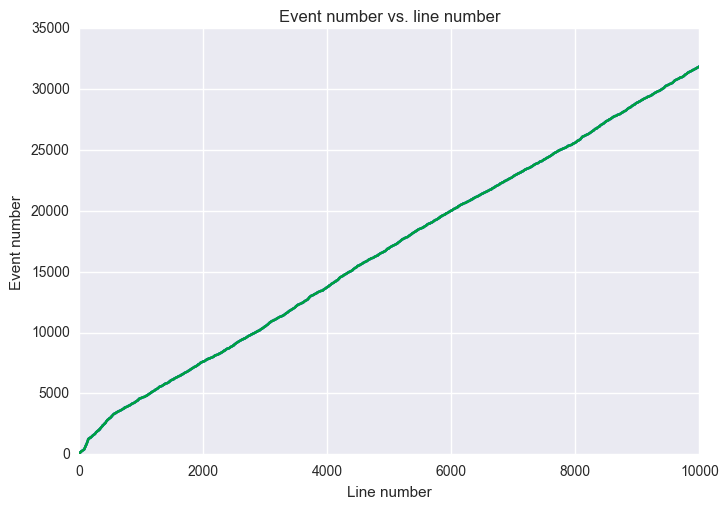

In [18]:
# Plot event number vs. line in
plt.plot(bicorr_data['event'])
plt.xlabel('Line number')
plt.ylabel('Event number')
plt.title('Event number vs. line number')
bicorr.save_fig_to_folder('/bicorr_all_evnum',fig_folder)
plt.show()

Try it as a function

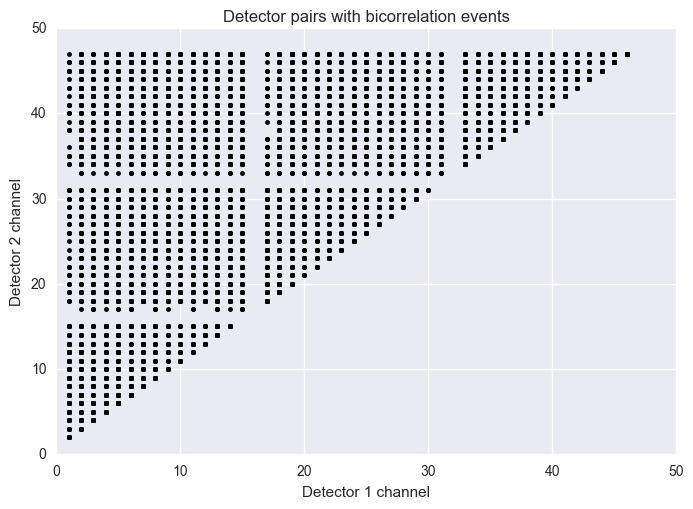

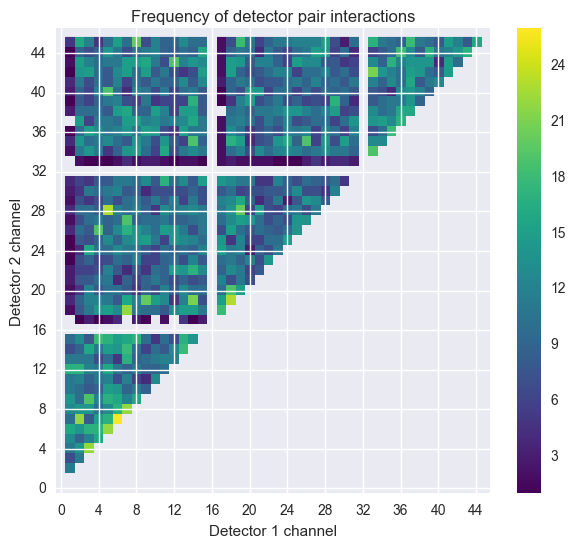

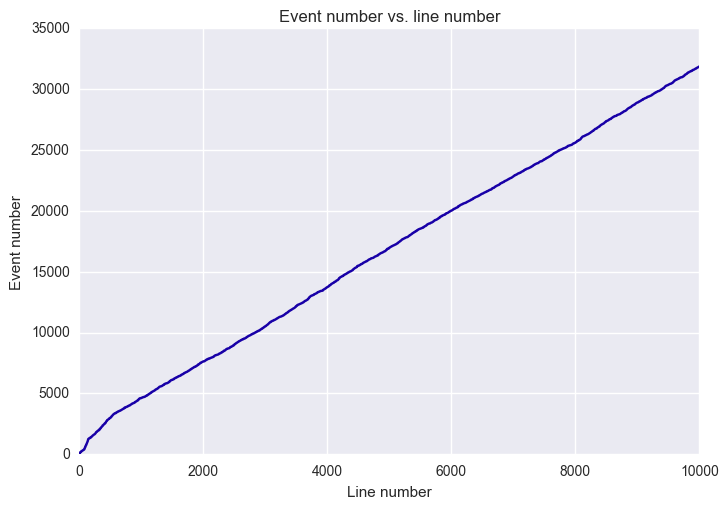

In [20]:
bicorr.bicorr_checkpoint_plots(bicorr_data, show_flag=True)

# Step 3) Preallocate massive matrix

We are going to store the `bicorr` events in a giant array of histograms called `bicorr_hist_master`, or `bhm` for short. The dimensions in the matrix will be:

0: 990 in length: detector pair index (indicated using dictionary `det_pair_dict`)  
1: 4 in length: interaction type (0=nn, 1=np, 2=pn, 3=pp)  
2: $\Delta t_1$ for detector 1  
3: $\Delta t_2$ for detector 2  

Thus, calling `bicorr_hist_master[0][0][:][:]` will produce the 2-d histogram for the 0th detector pair (ch 1 and ch 2) for nn interactions.

Set up this matrix.

## Time bins

Write a function that will generate `dt_bin_edges`. The length of this array will govern the number of bins in dimensions 2 ($\Delta t_1$) and 3 ($\Delta t_2$).

In [21]:
help(bicorr.build_dt_bin_edges)

Help on function build_dt_bin_edges in module bicorr:

build_dt_bin_edges(dt_min=-50, dt_max=200, dt_step=0.25, print_flag=False)
    Construct dt_bin_edges for the two-dimensional bicorrelation histograms. 
    
    Use as: dt_bin_edges, num_dt_bins = bicorr.build_dt_bin_edges()
    
    Parameters
    ----------
    dt_min : int, optional
        Lower time boundary
    dt_max : int, optional
        Upper time boundary
    dt_step : float, optional
        Time bin size
    print_flag : bool, optional
        Whether to print array details
        
    Returns
    -------
    dt_bin_edges : ndarray
        One-dimensional array of time bin edges
    num_dt_bins : ndarray
        Number of bins in time dimension



In [6]:
dt_bin_edges, num_dt_bins = bicorr.build_dt_bin_edges(print_flag=True)

Built array of dt bin edges from -50 to 200 in 1000 steps of 0.25 ns.


## Interaction type bins

In [7]:
# Number of bins in interaction type
num_intn_types = 4 #(0=nn, 1=np, 2=pn, 3=pp)

## Detector pair bins

In [8]:
# What are the unique detector numbers? Use same technique as in bicorr.py
chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists(print_flag=True)

Fission chamber channels: [ 0 16 32]
Detector channels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Number of detectors: 45
Number of detector pairs: 990


In [25]:
# Pre-allocate matrix
# Note: This is very memory intensive... can't run it too many times or python crashes.
bicorr_hist_master = np.zeros((num_det_pairs,num_intn_types,num_dt_bins,num_dt_bins),dtype=np.uint32)

In [14]:
bicorr_hist_master.shape

(990, 4, 1000, 1000)

How large will this be when we store it to disk?

In [15]:
bicorr_hist_master.nbytes/1e9

15.84

I had originally made the time range go from -200 to 200 ns, making for a 37 GB array. Now I am going from -50 to 200 which cuts it down to 15.84 GB. Now I can have two loaded in memory at a time. The further option still exists to make the time binning coarser to .5 ns instead of .25 ns.

## Functionalize this

Create a general method for allocating `bicorr_hist_master` based on default settings.

In [11]:
bicorr_hist_master = bicorr.alloc_bhm(num_det_pairs,num_intn_types,num_dt_bins)

# Step 4) Fill the histogram

I'm updating this with latest methods. I am not going to rerun the first two attempts, so they may not work in the future. I'm only going to update the third attempt, filling the histogram line-by-line.

## First attempt: use `np.where` to find indices, fill with `np.histogram2d`

Find the indices of the lines that will fill each detector type (based on detector pair and interaction type).

If this doesn't work, go line by line and fill the bins one at a time. But that's so boring.

In [10]:
# Pre-allocate matrix
# Note: This is very memory intensive... can't run it too many times or python crashes.
bicorr_hist_master = bicorr.alloc_bicorr_hist_master(num_det_pairs,num_intn_types,num_dt_bins)

In [23]:
# Loaded above in Step 1
bicorr_data.shape

(3611942,)

In [24]:
# Store a bunch of indices. Hopefully I won't run out of memory...
# Find event indices for each event type
type0_indices = np.where(np.logical_and(bicorr_data['det1par']==1,bicorr_data['det2par']==1))
type1_indices = np.where(np.logical_and(bicorr_data['det1par']==1,bicorr_data['det2par']==2))
type2_indices = np.where(np.logical_and(bicorr_data['det1par']==2,bicorr_data['det2par']==1))
type3_indices = np.where(np.logical_and(bicorr_data['det1par']==2,bicorr_data['det2par']==2))

In [25]:
np.sum(type0_indices[0].shape+type1_indices[0].shape+type2_indices[0].shape+type3_indices[0].shape)

3611942

How can I quickly return the index?

In [27]:
# Set up dictionary for returning detector pair index
det_df = bicorr.load_det_df()
dict_index_to_pair = det_df['d1d2'].to_dict()
dict_pair_to_index = {v: k for k, v in dict_index_to_pair.items()}

# Loop through all pairs and fill the histogram
start_time = time.time()
count = 0   # Running total of selected indices 
count2 = 0  # Running sum of histogram counts
for i1 in np.arange(0, num_dets): # Just run det1ch = 1 for the time being due to memory constraints.
    det1ch = detList[i1]
    print(str(det1ch)+'---')
    for i2 in np.arange(i1+1,num_dets):
        det2ch = detList[i2]
        det_pair_indices = np.where(np.logical_and(bicorr_data['det1ch']==det1ch,bicorr_data['det2ch']==det2ch))
        
        # type interactions
        selected_type0 = np.intersect1d(det_pair_indices, type0_indices)
        selected_type1 = np.intersect1d(det_pair_indices, type1_indices)
        selected_type2 = np.intersect1d(det_pair_indices, type2_indices)
        selected_type3 = np.intersect1d(det_pair_indices, type3_indices)
        count = count + np.sum(selected_type0.shape+selected_type1.shape+selected_type2.shape+selected_type3.shape)
        
        # Adding these count2 lines for debugging to search for the error
        count2 += np.sum(np.histogram2d(bicorr_data['det1t'][selected_type0],bicorr_data['det2t'][selected_type0],bins=dt_bin_edges)[0])
        count2 += np.sum(np.histogram2d(bicorr_data['det1t'][selected_type1],bicorr_data['det2t'][selected_type1],bins=dt_bin_edges)[0])
        count2 += np.sum(np.histogram2d(bicorr_data['det1t'][selected_type2],bicorr_data['det2t'][selected_type2],bins=dt_bin_edges)[0])
        count2 += np.sum(np.histogram2d(bicorr_data['det1t'][selected_type3],bicorr_data['det2t'][selected_type3],bins=dt_bin_edges)[0])
       
        bicorr_hist_master[dict_pair_to_index[100*det1ch+det2ch],0,:,:] = np.histogram2d(bicorr_data['det1t'][selected_type0],bicorr_data['det2t'][selected_type0],bins=dt_bin_edges)[0]
        bicorr_hist_master[dict_pair_to_index[100*det1ch+det2ch],1,:,:] = np.histogram2d(bicorr_data['det1t'][selected_type1],bicorr_data['det2t'][selected_type1],bins=dt_bin_edges)[0]
        bicorr_hist_master[dict_pair_to_index[100*det1ch+det2ch],2,:,:] = np.histogram2d(bicorr_data['det1t'][selected_type2],bicorr_data['det2t'][selected_type2],bins=dt_bin_edges)[0]
        bicorr_hist_master[dict_pair_to_index[100*det1ch+det2ch],3,:,:] = np.histogram2d(bicorr_data['det1t'][selected_type3],bicorr_data['det2t'][selected_type3],bins=dt_bin_edges)[0]

print('Run time: ', time.time()-start_time)        
print('Sum of bicorr_hist_master: ', np.sum(bicorr_hist_master))
print('Running total of type_indices_#: ', count)
print('Running total of histogram sum: ', count2)

1---


C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2822: RuntimeWarning: overflow encountered in multiply
  return round(decimals, out)


2---
3---
4---
5---
6---
7---
8---
9---
10---
11---
12---
13---
14---
15---
17---
18---
19---
20---
21---
22---
23---
24---
25---
26---
27---
28---
29---
30---
31---
33---
34---
35---
36---
37---
38---
39---
40---
41---
42---
43---
44---
45---
46---
47---
Run time:  212.27839994430542
Sum of bicorr_hist_master:  3188297
Running total of type_indices_#:  3611942
Running total of histogram sum:  3188297.0


This shows that events are getting lost at some point. The total number of events in the histogram do not match the number of events in `bicorr_data`. Where are they going? It is possible that those are events outside of the boundaries of `dt_bin_edges`. How many events are getting lost?

In [28]:
# How many lines are left out of the histogram?
count-count2

423645.0

Are the missing events those in which the time is out of range of the time axes?

In [32]:
t_min = dt_bin_edges[0]; t_max = dt_bin_edges[-1]
print(t_min,t_max)

over1 =  np.ndarray.flatten(np.argwhere(bicorr_data['det1t']>=t_max))
under1 = np.ndarray.flatten(np.argwhere(bicorr_data['det1t']<=t_min))
over2 =  np.ndarray.flatten(np.argwhere(bicorr_data['det2t']>=t_max))
under2 = np.ndarray.flatten(np.argwhere(bicorr_data['det2t']<=t_min))

overunder = np.concatenate([over1, under1, over2, under2])
np.unique(overunder).shape

-50.0 200.0


(741761,)

There are more events outside of the range of `dt_bin_edges` than are being left out of the histogram. So I am not sure what this means. Last time the numbers were exactly the same.

I believe the problem is in using np.histogram2d, which returns a overflow warning. I believe the problem is in passing in the time stamps as floats, there is an overflow error, which is causing some counts to be lost. 

I am not going to spend any more time on this because the next section shows that the line-by-line method is much faster and I will use that method instead.

## Second attempt: Fill the array all at once using `np.histogramdd`

`np.histogramdd`, documentation here: <https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogramdd.html#numpy.histogramdd>

Compute the multidimensional histogram of some data.

The four dimensions are:

* Detector pair.
* Interaction type
* `det1t`
* `det2t`

This will take some work, since I will have to figure out how to provide the bins of the first two dimensions. Keep this in mind, but move on to the next method.

## Third attempt: Fill line-by-line by calculating bin index

Instead of filling time histograms for given event type and detector pair, simply go through line by line and increase the count in the corresponding bin from `bicorr_hist_master`. 

In [9]:
bhm = bicorr.alloc_bhm(num_det_pairs,num_intn_types,num_dt_bins)

In [10]:
# Set up dictionary for returning detector pair index
det_df = bicorr.load_det_df()
dict_pair_to_index, dict_index_to_pair = bicorr.build_dict_det_pair(det_df)

In [11]:
# Type index
dict_type_to_index = {11:0, 12:1, 21:2, 22:3}

# Time indices
dt_min = np.min(dt_bin_edges); dt_max = np.max(dt_bin_edges)
dt_step = dt_bin_edges[1]-dt_bin_edges[0]

I will use the following equation to determine the time bin. 

$$ \text{bin}(t) = \lfloor \frac{t-t_{min}}{\Delta t}\rfloor$$


In [35]:
count_loss = 0
start_time = time.time()
for i in tqdm(np.arange(bicorr_data.shape[0]),ascii=True):
    # What is the corresponding bin number for the four dimensions?
    ## Detector pair index
    pair_i = dict_pair_to_index[bicorr_data[i]['det1ch']*100+bicorr_data[i]['det2ch']]
    ## Event type index
    type_i = dict_type_to_index[bicorr_data[i]['det1par']*10+bicorr_data[i]['det2par']]
    ## Time 1 index
    t1_i = int(np.floor((bicorr_data[i]['det1t']-dt_min)/dt_step))
    t1_i_check = np.logical_and(t1_i>=0, t1_i<num_dt_bins) # Within range?
    ## Time 2 index
    t2_i = int(np.floor((bicorr_data[i]['det2t']-dt_min)/dt_step))
    t2_i_check = np.logical_and(t2_i>=0, t2_i<num_dt_bins) # Within range?
    
    if np.logical_and(t1_i_check, t2_i_check):    
        # Increment the corresponding bin
        bhm[pair_i,type_i,t1_i,t2_i] += 1
    else:
        count_loss += 1
        
    
print(np.sum(bhm))
print(time.time()-start_time)

100%|##########| 10000/10000 [00:00<00:00, 40719.34it/s]


16096
13.99218487739563


In [36]:
count_loss

1952

This method is much faster so we will use it.

## Functionalize this with default settings

In [37]:
print(inspect.getsource(bicorr.fill_bhm))

def fill_bhm(bicorr_hist_master, bicorr_data, det_df, dt_bin_edges, disable_tqdm = False):
    """
    Fill bicorr_hist_master. Structure:
        Dimension 0: detector pair, use dictionary `dict_pair_to_index`  
        Dimension 1: interaction type, length 4. (0=nn, 1=np, 2=pn, 3=pp)  
        Dimension 2: dt bin for detector 1
        Dimension 3: dt bin for detector 2
    
    Must have allocated bicorr_hist_master and loaded bicorr_data
    
    Parameters
    ----------
    bicorr_hist_master : ndarray
        Master histogram of bicorrelation histograms across all detector pairs and interaction types.
        Dimension 0: detector pair, use dictionary `dict_pair_to_index` where pair is (100*det1ch+det2ch)  
        Dimension 1: interaction type, length 4. (0=nn, 1=np, 2=pn, 3=pp)  
        Dimension 2: dt bin for detector 1
        Dimension 3: dt bin for detector 2
    bicorr_data : ndarray
        Each element contains the following info for one bicorrelation pair
        Colu

In [12]:
bhm = bicorr.alloc_bhm(num_det_pairs,num_intn_types,num_dt_bins)

In [13]:
bhm = bicorr.fill_bhm(bhm, bicorr_data, det_df, dt_bin_edges)

100%|##########| 10000/10000 [00:00<00:00, 53763.41it/s]


# Step 5) Convert to sparse matrix

As developed in my notebook [implement_sparse_matrix](implement_sparse_matrix.ipynb).

In [14]:
sparse_bhm = bicorr.generate_sparse_bhm(bhm)

100%|##########| 8026/8026 [00:00<00:00, 236059.38it/s]


# Step 6) Save the histogram and related vectors to disk

## The full `bicorr_hist_master` array

I'm going to use `np.savez` to save several arrays in the same `.npz` file.

CAUTION: This will store at 15 GB file to your hard drive. I can verify that it works. No need to repeat it. Instead, use the sparse matrix technique.

In [ ]:
# np.savez('../datar/1/bicorr_hist_master', bicorr_hist_master = bicorr_hist_master, dict_pair_to_index=dict_pair_to_index, dt_bin_edges=dt_bin_edges)

## The sparse `bicorr_hist_master` array

I also developed a method for storing the `bicorr_hist_master` as a sparse array, which requires much less space. Save that to disk instead.

In [15]:
bicorr.save_sparse_bhm(sparse_bhm, det_df, dt_bin_edges, save_folder = '../datar/1')

# Functionalize it

 Put it all together in a function with default settings

It will be convenient to generate the bicorrelation histogram for data in one step based on default settings. 

The steps are:

* Load relevant information
    * `det_df`
    * `root_path`
    * `dt_bin_edges`
    * `num_det_pairs`, `num_intn_types`
* Allocate empty bicorr hist master: `bhm`
* Loop through all folders
    * Load `bicorr_data`
    * Create checkpoint plots
    * Fill `bhm`
* If `save_flag`
    * Build sparse matrix
    * Save sparse matrix to file
* Return `bhm`, `dt_bin_edges`

In [5]:
help(bicorr.build_bhm)

Help on function build_bhm in module bicorr:

build_bhm(det_df=None, folder_start=1, folder_end=2, dt_bin_edges=None, checkpoint_flag=True, save_flag=True, root_path=None, disable_tqdm=False, print_flag=True)
    Load bicorr_data from folder's bicorr# file and fill histogram. Loop through folders specified by `folder_start` and `folder_end`. Built for dt_bin_edges generated using default settings in bicorr.build_dt_bin_edges().
    
    Parameters
    ----------
    det_df : pandas dataFrame, optional
        dataFrame of detector pair indices and angles   
        Default is to look for the file in '../meas_info/det_df_pairs_angles.csv'
    folder_start : int, optional
        First folder
    folder_end : int, optional
        Last folder + 1 (for example, folder_end = 2 will end at folder 1)
    dt_bin_edges : ndarray, optional
        Edges of time bin array in ns
        If None, use default settings from build_dt_bin_edges()
    checkpoint_flag : bool, optional
        Generate c

In [58]:
bhm, dt_bin_edges = bicorr.build_bhm(det_df,1,2,dt_bin_edges =dt_bin_edges, checkpoint_flag = True,save_flag = False, disable_tqdm = True)
bicorr_hist_master.shape

Generating bicorr histogram for bicorr data in folders:  [1]
Loading data in folder  1
Building bicorr_hist_master in folder  1


(990, 4, 800, 800)

In [6]:
bhm, dt_bin_edges = bicorr.build_bhm(root_path = '../datar/')

Generating bicorr histogram for bicorr data in folders:  [1]
Loading data in folder  1
Building bhm in folder  1


100%|##########| 695/695 [00:00<00:00, 695050.38it/s]


Generating sparse matrix


100%|##########| 531/531 [00:00<?, ?it/s]


Saving sparse matrix data to .npz file
Bicorr hist master bhm build complete


In [8]:
bhm, dt_bin_edges = bicorr.build_bhm(folder_end = 3, root_path = '../datar/')

Generating bicorr histogram for bicorr data in folders:  [1 2]
Loading data in folder  1
Building bhm in folder  1


100%|##########| 695/695 [00:00<00:00, 46333.01it/s]


Loading data in folder  2
Building bhm in folder  2


100%|##########| 695/695 [00:00<00:00, 57916.26it/s]


Generating sparse matrix


100%|##########| 531/531 [00:00<00:00, 265487.59it/s]


Saving sparse matrix data to .npz file
Bicorr hist master bhm build complete
